In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image
from scipy.ndimage import shift

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat/'
gpu = 1
torch.cuda.set_device(gpu)
workers = 8
epoch = 10
start_epoch = 0
vbity = 20
esize = 4

way = 20
evalway = 5
trainshot = 5
testshot = 15

In [4]:
# Load Training/Testing Data

d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, flipping, masking, offset):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (size,size), mode='constant', cval=0)
        if offset != 0:
            xoff = np.random.choice(list(range(offset)))
            yoff = offset-xoff
            xoff *= np.random.choice([-1,1])
            yoff *= np.random.choice([-1,1])
            mask = shift(mask, [xoff, yoff], order=0, mode='constant', cval=0)
        t = torch.cat([t, torch.FloatTensor(mask).unsqueeze(0)], dim=0)
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source, way):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        self.way = way
        
    def __iter__(self):
        # Build new dictionary, shuffle entries
        trackdict = deepcopy(self.iddict)
        for key in trackdict:
            np.random.shuffle(trackdict[key])
        # Choose categories, sample, eliminate small categories
        idlist = []
        while len(trackdict.keys()) >= self.way:
            cats = np.random.choice(list(trackdict.keys()), size=self.way, replace=False)
            for cat in cats:
                for _ in range(trainshot):
                    idlist.append(trackdict[cat].pop())
            for cat in cats:
                for _ in range(testshot):
                    idlist.append(trackdict[cat].pop())
                if len(trackdict[cat]) < trainshot+testshot:
                    trackdict.pop(cat)
            # TODO: shuffle idlist batches
            yield idlist
            idlist = []

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, True, True, 1))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, False, True, 0))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset, way),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset, evalway),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
908 227


In [5]:
# Define the Procedures

def train(train_loader, epoch, gpu, vbity):
    for model in smodel:
        model.train()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*way)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    for i, (inp, _) in enumerate(train_loader):
        inp = Variable(inp).cuda(device = gpu, async=True)
        
        for j in range(esize):
            smodel[j].zero_grad()
            out = predictor(smodel[j](inp), way, trainshot)
            loss = criterion(out, targ)
            loss.backward()
            soptimizer[j].step()
        
            allloss[j] += loss.item()
            
        if i%vbity == 0:
            print('%d of approx. 192270'%(i*way*(trainshot+testshot)))
    return [L/i for L in allloss]

def validate(val_loader, gpu, vbity, reps, verbose):
    for model in smodel:
        model.eval()
    targ = Variable(torch.LongTensor([i//testshot for i in range(testshot*evalway)])).cuda(
        device = gpu, async=True)
    allloss = [0]*esize
    acctracker = [[] for _ in range(esize)]
    for r in range(reps):
        for i, (inp, _) in enumerate(val_loader):
            inp = Variable(inp).cuda(device = gpu, async=True)

            with torch.no_grad():
                for j in range(esize):
                    out = predictor(smodel[j](inp), evalway, trainshot)
                    loss = criterion(out, targ)
                    allloss[j] += loss.item()
                    _,bins = torch.max(out,1)
                    acc = torch.sum(torch.eq(bins,targ)).item()/testshot/evalway
                    acctracker[j].append(acc)
            if i%vbity == 0 and verbose:
                print('Round %d of %d, %d of approx. 51716'%(r+1, reps, i*evalway*(trainshot+testshot)))
    return [L/i for L in allloss], [np.mean(a) for a in acctracker], [1.96*np.sqrt(np.var(a)/len(a)) for a in acctracker]

print('Ready to go!')

Ready to go!


In [6]:
# Make Models

class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

class PROTO(nn.Module):
    def __init__(self):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(4,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        return self.process(inp).view(inp.size(0),-1)
        
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, inp, way, trainshot):
        support = inp[:way*trainshot].view(way,-1,inp.size(-1)).mean(1).squeeze()
        distmat = torch.sum((support.unsqueeze(0)-inp[way*trainshot:].unsqueeze(1))**2,2).squeeze().neg()
        probs = self.sm(distmat)
        return probs
    
smodel = [PROTO().cuda() for i in range(esize)]
qmodel = [PROTO().cuda() for i in range(esize)]
predictor = Predictor().cuda()
soptimizer = [optim.Adam(m.parameters(), lr=.001) for m in smodel]
qoptimizer = [optim.Adam(m.parameters(), lr=.001) for m in qmodel]
sscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in soptimizer]
qscheduler = [optim.lr_scheduler.LambdaLR(o, lambda x: 1/(2**x)) for o in qoptimizer]
criterion = nn.NLLLoss().cuda()
cudnn.benchmark = True

nweights = sum([i.numel() for i in list(smodel[0].parameters())])
print(nweights," parameters in each neural net.")

113664  parameters in each neural net.


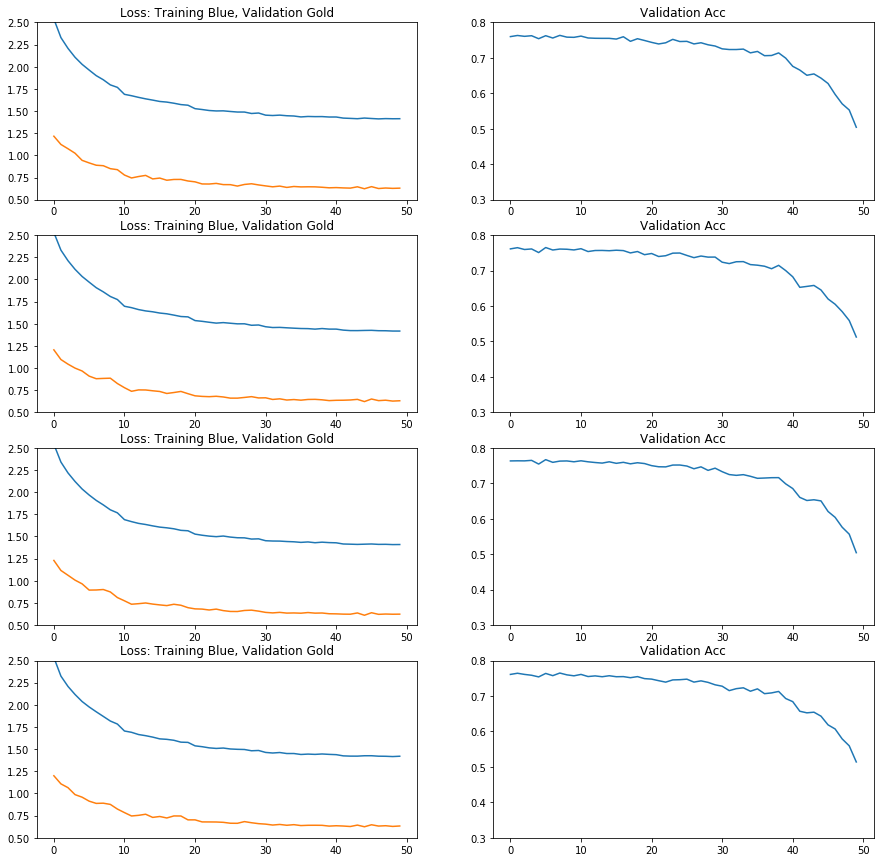

Train loss is: [1.4134164452552795, 1.4174194356402614, 1.4089704739177686, 1.4203014311104885]
Validation accuracy is: [0.7599086757990867, 0.7611872146118721, 0.7630441400304415, 0.7608523592085236]
Validation loss is: [0.6297646579876098, 0.6309854612606887, 0.6233774760154074, 0.6332707432369346]

0.27 hours to completion

13.275449530879657 hours total
Model 0 final score: 76.21 +- 0.27
Model 1 final score: 76.18 +- 0.27
Model 2 final score: 76.49 +- 0.27
Model 3 final score: 76.13 +- 0.27


In [7]:
# Do the Thing!

start = time.time()
trainlosses, testlosses, acctracker = [[] for _ in range(esize)],[[] for _ in range(esize)],[[] for _ in range(esize)]
epochs = 5*epoch
for e in range(epochs):
    # Adjust learnrate
    if e%epoch == 0:
        [s.step() for s in sscheduler]
        [q.step() for q in qscheduler]
    
    # Train for one epoch
    trainloss = train(train_loader, e, gpu, vbity)
    
    # Evaluate, single pass
    testloss, acc, _ = validate(test_loader, gpu, vbity, 1, True)
    
    # update the precision graph, report
    display.clear_output(wait=True)
    for j in range(esize):
        trainlosses[j].append(trainloss[j])
        testlosses[j].append(testloss[j])
        acctracker[j].append(acc[j])
    pl.figure(1, figsize=(15,15))
    for i in range(esize):
        pl.subplot(esize,2,2*i+1)
        pl.plot(trainlosses[i])
        pl.plot(testlosses[i])
        pl.ylim((.5,2.5))
        pl.title("Loss: Training Blue, Validation Gold")
        pl.subplot(esize,2,2*i+2)
        pl.plot(acctracker[i][::-1])
        pl.ylim((0.3,.8))
        pl.title("Validation Acc")
    pl.show()
    print("Train loss is: "+str(trainloss)+
            "\nValidation accuracy is: "+str(acc)+
            "\nValidation loss is: "+str(testloss)+"\n")
    
    print("%.2f hours to completion"%(  (time.time()-start)/(e+1)*(epochs-e)/3600  ))
    print()
print((time.time()-start)/3600, "hours total") 
_, score, conf = validate(test_loader, gpu, vbity, 10, False)
for i in range(esize):
    print('Model %d final score: %.2f +- %.2f'%(i, score[i]*100, conf[i]*100))

In [ ]:
%%javascript
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>